In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from upsetplot import UpSet
from upsetplot import from_contents
from gseapy import enrichr

import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import os
from anndata import AnnData

In [153]:
import gseapy as gp
import seaborn as sns

In [ ]:
adata=sc.read_h5ad("/exports/archive/hg-funcgenom-research/Genelab_dataset/OSD-562/adata_raw.h5ad")

In [5]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
adata.obs['group_cluster'] = adata.obs['Parameter Value: absorbed radiation dose'].astype(str) + '_' + adata.obs['leiden'].astype(str)

In [17]:
## Removed group_cluster that only has few sample
group_counts = adata.obs['group_cluster'].value_counts()

In [25]:
group_counts

group_cluster
Not Applicable_0      21295
10.428 milligray_0    13845
Not Applicable_1       9478
17.655 milligray_0     9177
Not Applicable_2       7296
17.334 milligray_0     6951
10.428 milligray_2     5405
10.428 milligray_1     4461
17.655 milligray_1     4228
17.655 milligray_2     4069
17.013 milligray_0     3851
10.428 milligray_5     3406
Not Applicable_3       3340
18.032 milligray_0     2793
17.334 milligray_2     2690
17.334 milligray_1     2689
17.013 milligray_1     2339
Not Applicable_4       2130
17.013 milligray_2     2077
17.334 milligray_4     1867
17.655 milligray_3     1529
10.428 milligray_3     1494
10.428 milligray_4     1188
18.032 milligray_1      897
17.013 milligray_3      869
17.655 milligray_4      856
18.032 milligray_2      834
Not Applicable_6        784
17.334 milligray_3      656
Not Applicable_5        605
17.013 milligray_4      565
18.032 milligray_3      281
17.013 milligray_5      225
18.032 milligray_4      184
10.428 milligray_6      151
17.655

In [39]:
df=pd.DataFrame(group_counts)
df["group_cluster"]=df.index.tolist()
df[['radiation', 'cluster']] =df["group_cluster"].str.split('_', expand=True)

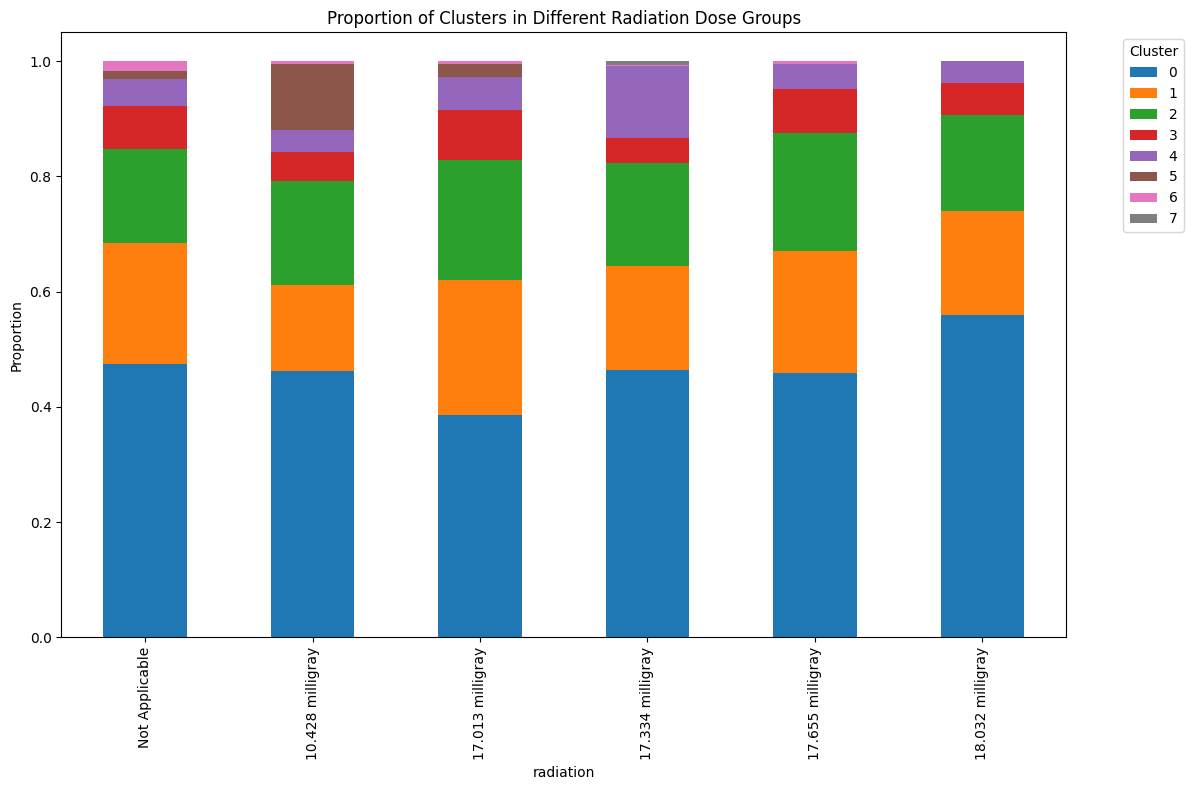

In [99]:
df['radiation_numeric'] = pd.to_numeric(df['radiation'].str.extract(r'(\d+\.\d+)', expand=False), errors='coerce')

df['radiation_numeric'] = df['radiation_numeric'].fillna(-1)

df_sorted = df.sort_values(by='radiation_numeric')

custom_order = ['Not Applicable'] + df_sorted['radiation'].unique().tolist()
custom_order.remove('Not Applicable')  # Remove 'Not Applicable' from the list

pivot_df = df_sorted.pivot_table(index='radiation', columns='cluster', values='count', aggfunc='sum', fill_value=0)

pivot_df = pivot_df.reindex(custom_order)

proportions_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

proportions_df.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.ylabel('Proportion')
plt.title('Proportion of Clusters in Different Radiation Dose Groups')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
clusters = adata.obs['leiden'].unique()
groups = adata.obs['Parameter Value: absorbed radiation dose'].unique()

results_list = []

for cluster in clusters:
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    unique_groups = adata_cluster.obs['Parameter Value: absorbed radiation dose'].unique()
    
    if len(unique_groups) < 2:
        print(f"Not enough groups for cluster {cluster}. Skipping.")
        continue
    
    valid_groups = unique_groups[adata_cluster.obs['Parameter Value: absorbed radiation dose'].value_counts() > 1]
    
    if len(valid_groups) < 2:
        print(f"Not enough valid groups for cluster {cluster}. Skipping.")
        continue

    try:
        sc.tl.rank_genes_groups(adata_cluster, groupby='Parameter Value: absorbed radiation dose', method='wilcoxon', reference="Not Applicable")
        
        if 'names' in adata_cluster.uns['rank_genes_groups']:
            for group in adata_cluster.uns['rank_genes_groups']['names'].dtype.names:
                gene_names = adata_cluster.uns['rank_genes_groups']['names'][group]
                pvals = adata_cluster.uns['rank_genes_groups']['pvals'][group]
                logfc = adata_cluster.uns['rank_genes_groups']['logfoldchanges'][group]
                
                # Append results to the list
                results_list.append({
                    'cluster': cluster,
                    'group': group,
                    'genes': gene_names,
                    'pvals': pvals,
                    'logfc': logfc
                })
        else:
            print(f"No differential expression results for cluster {cluster}.")
    
    except ValueError as e:
        print(f"Error processing cluster {cluster}: {e}")
    
if results_list:
    results_df = pd.DataFrame(results_list)
    
    filtered_results_df = results_df[(results_df['logfc'] > 0) & (results_df['pvals'] < 0.05)]
    
    # Create separate UpSet plots for each cluster
    for cluster in filtered_results_df['cluster'].unique():
        cluster_data = filtered_results_df[filtered_results_df['cluster'] == cluster]
        
        gene_sets = {}
        for group in cluster_data['group'].unique():
            gene_sets[group] = set(cluster_data.loc[cluster_data['group'] == group, 'genes'])
        
        upset_data = pd.DataFrame(0, index=cluster_data['genes'].unique(), columns=cluster_data['group'].unique())
        
        for group in gene_sets:
            upset_data.loc[gene_sets[group], group] = 1
        
        upset = UpSet(upset_data, subset_size='count', sort_by='count')
        upset.plot()

        plt.title(f'Common Differentially Expressed Genes for Cluster {cluster}')
        plt.show()
else:
    print("No results were generated.")

In [86]:
results_df = pd.DataFrame(results_list)
results_flat = results_df.explode(['genes', 'pvals', 'logfc'])

results_flat['pvals'] = pd.to_numeric(results_flat['pvals'], errors='coerce')
results_flat['logfc'] = pd.to_numeric(results_flat['logfc'], errors='coerce')

In [271]:
filtered_results_df = results_flat[(results_flat['logfc'] > 0) & (results_flat['pvals'] < 0.05)]

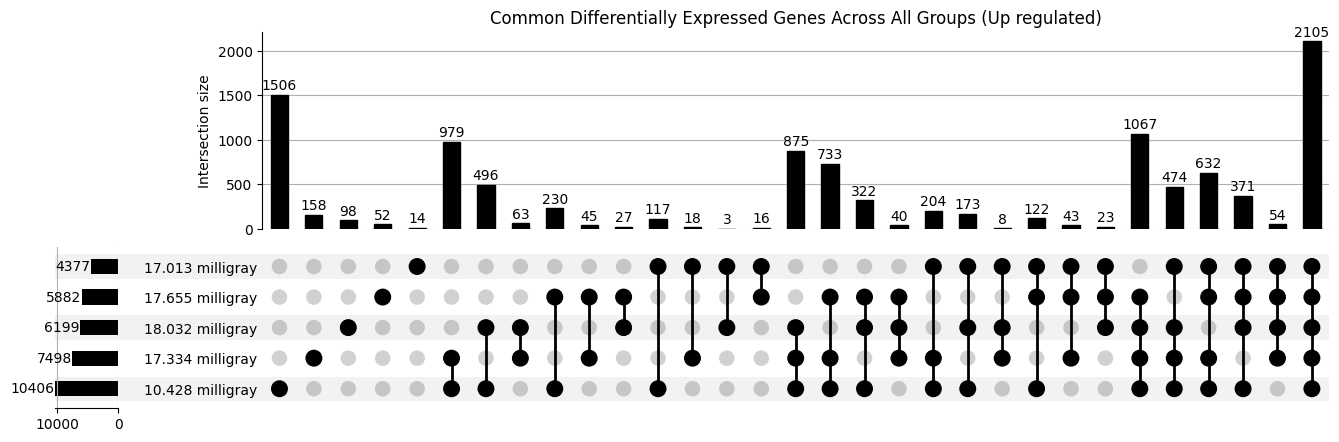

<Figure size 800x1000 with 0 Axes>

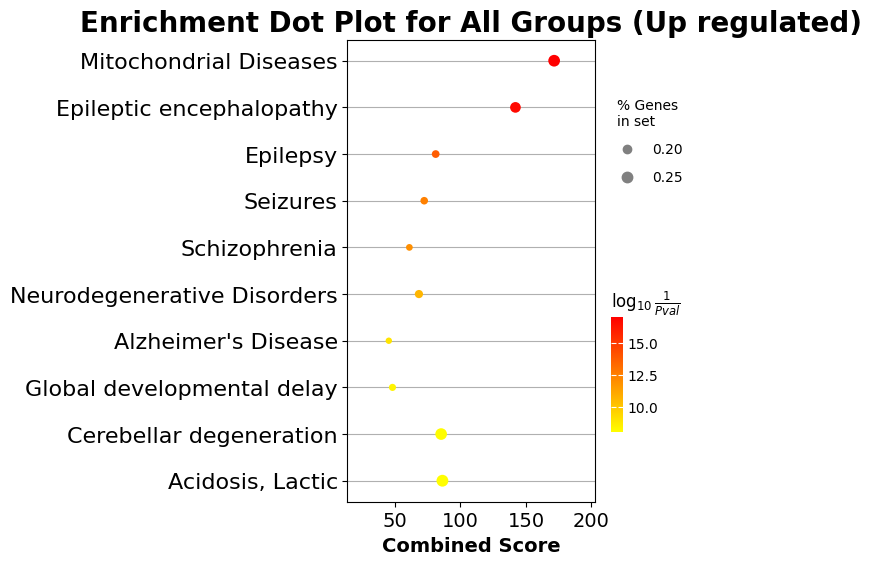

Enrichment results for all groups:


In [272]:
output_dir = "enrichment_results/Up_regulated"
os.makedirs(output_dir, exist_ok=True)

enrichment_results_dir = "enrichment_results/Up_regulated"
os.makedirs(enrichment_results_dir, exist_ok=True)

group_1 = filtered_results_df[filtered_results_df['group'] == '10.428 milligray']['genes'].explode().unique().tolist()
group_2 = filtered_results_df[filtered_results_df['group'] == '17.013 milligray']['genes'].explode().unique().tolist()
group_3 = filtered_results_df[filtered_results_df['group'] == '17.334 milligray']['genes'].explode().unique().tolist()
group_4 = filtered_results_df[filtered_results_df['group'] == '17.655 milligray']['genes'].explode().unique().tolist()
group_5 = filtered_results_df[filtered_results_df['group'] == '18.032 milligray']['genes'].explode().unique().tolist()

radiation_DGE = from_contents(
    {
        "10.428 milligray": group_1,
        "17.013 milligray": group_2,
        "17.334 milligray": group_3,
        "17.655 milligray": group_4,
        "18.032 milligray": group_5
    }
)

ax_dict = UpSet(radiation_DGE, subset_size="count", show_counts=True).plot()

plt.title('Common Differentially Expressed Genes Across All Groups (Up regulated)')
plt.savefig(os.path.join(output_dir, 'upset_plot_all_groups.png'))

plt.show()

overlapping_genes = set(group_1).intersection(group_2, group_3, group_4, group_5)

if not overlapping_genes:
    print('No overlapping genes across all groups. Skipping enrichment analysis.')
else:
    overlapping_genes_list = list(overlapping_genes)

    results = enrichr(gene_list=overlapping_genes_list, gene_sets='DisGeNET', outdir=enrichment_results_dir)

    results.res2d.Term = results.res2d.Term.str.split(" \(GO").str[0]

    plt.figure(figsize=(8, 10))
    gp.dotplot(results.res2d, title='Enrichment Dot Plot for All Groups (Up regulated)', cmap=plt.cm.autumn_r)

    plt.savefig(os.path.join(enrichment_results_dir, 'dot_plot_all_groups.png'))
    plt.show()  


    enrichment_results_file = os.path.join(enrichment_results_dir, 'enrichment_results_all_groups.tsv')
    results.res2d.to_csv(enrichment_results_file, sep='\t')

In [273]:
filtered_results_df = results_flat[(results_flat['logfc'] < 0) & (results_flat['pvals'] < 0.05)]

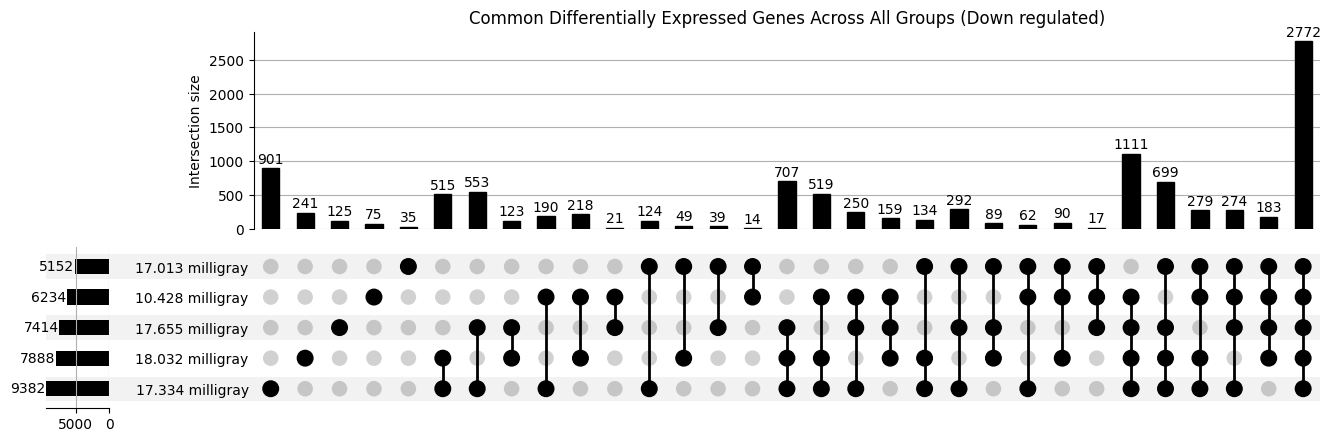

<Figure size 800x1000 with 0 Axes>

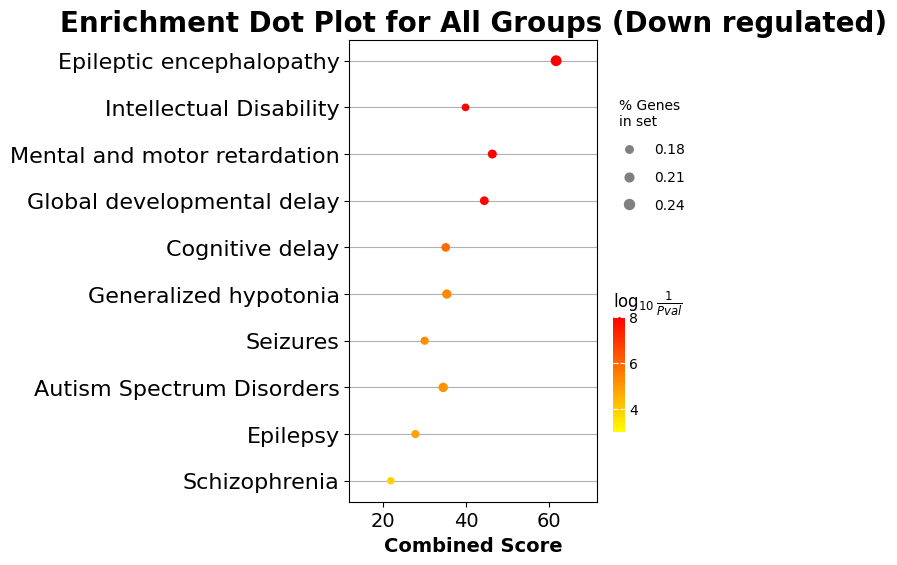

Enrichment results for all groups:


In [274]:
output_dir = "enrichment_results/Down_regulated"
os.makedirs(output_dir, exist_ok=True)

enrichment_results_dir = "enrichment_results/Down_regulated"



group_1 = filtered_results_df[filtered_results_df['group'] == '10.428 milligray']['genes'].explode().unique().tolist()
group_2 = filtered_results_df[filtered_results_df['group'] == '17.013 milligray']['genes'].explode().unique().tolist()
group_3 = filtered_results_df[filtered_results_df['group'] == '17.334 milligray']['genes'].explode().unique().tolist()
group_4 = filtered_results_df[filtered_results_df['group'] == '17.655 milligray']['genes'].explode().unique().tolist()
group_5 = filtered_results_df[filtered_results_df['group'] == '18.032 milligray']['genes'].explode().unique().tolist()

radiation_DGE = from_contents(
    {
        "10.428 milligray": group_1,
        "17.013 milligray": group_2,
        "17.334 milligray": group_3,
        "17.655 milligray": group_4,
        "18.032 milligray": group_5
    }
)

ax_dict = UpSet(radiation_DGE, subset_size="count", show_counts=True).plot()

plt.title('Common Differentially Expressed Genes Across All Groups (Down regulated)')
plt.savefig(os.path.join(output_dir, 'upset_plot_all_groups.png'))

plt.show()

overlapping_genes = set(group_1).intersection(group_2, group_3, group_4, group_5)

if not overlapping_genes:
    print('No overlapping genes across all groups. Skipping enrichment analysis.')
else:
    overlapping_genes_list = list(overlapping_genes)

    results = enrichr(gene_list=overlapping_genes_list, gene_sets='DisGeNET', outdir=enrichment_results_dir)

    results.res2d.Term = results.res2d.Term.str.split(" \(GO").str[0]

    plt.figure(figsize=(8, 10))
    gp.dotplot(results.res2d, title='Enrichment Dot Plot for All Groups (Down regulated)', cmap=plt.cm.autumn_r)

    plt.savefig(os.path.join(enrichment_results_dir, 'dot_plot_all_groups.png'))
    plt.show()  

    print('Enrichment results for all groups:')
    print(results)

    enrichment_results_file = os.path.join(enrichment_results_dir, 'enrichment_results_all_groups.tsv')
    results.res2d.to_csv(enrichment_results_file, sep='\t')